In [4]:
import numpy as np
import duckdb
import pandas as pd
#import seaborn as sns
import statsmodels.formula.api as sfm
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from scipy.stats import norm
import matplotlib.pyplot as plt

# What type of shots yield more success?

There are many different types of shots that a hockey player can play, however some type of shots might have a greater success rate than others in making a goal.

In [5]:
df = pd.read_csv('BDC_2024_Womens_Data.csv')

In [6]:
df.columns

Index(['Date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2'],
      dtype='object')

In [7]:
query = """
        SELECT Event, "Detail 1" AS "Shot Type", 
        FROM df
        WHERE Event = 'Goal' OR Event = 'Shot'
        """
shots_df = duckdb.sql(query).df()
shots_df

,Event,Shot Type
0,Goal,Wristshot
1,Goal,Wristshot
2,Goal,Snapshot
3,Goal,Wristshot
4,Shot,Snapshot
...,...,...
418,Shot,Wristshot
419,Shot,Wristshot
420,Shot,Wristshot
421,Shot,Wristshot


In [8]:
shots_df['Shot Type'].unique()

array(['Wristshot', 'Snapshot', 'Fan', 'Slapshot', 'Deflection',
       'Wrap Around', 'Bat', 'Poke'], dtype=object)

There are 8 different types of shots: Wristshot, Snapshot, Fan, Slapshot, Deflection, Wrap Around, Bat, and Poke.

In [9]:
query = """
        SELECT "Shot Type", 
        COUNT(Event) AS "Total Attempted",
        COUNT (CASE WHEN Event = 'Goal' THEN 1 END) AS "Success"
        FROM shots_df
        GROUP BY "Shot Type"
        """

df = duckdb.sql(query).df()
df

,Shot Type,Total Attempted,Success
0,Fan,11,0
1,Snapshot,167,8
2,Poke,1,0
3,Slapshot,27,1
4,Deflection,27,2
5,Bat,1,0
6,Wristshot,185,9
7,Wrap Around,4,0


In [10]:
df['Success Rate'] = round((df['Success'] / df['Total Attempted'] ) , 4) * 100
df

,Shot Type,Total Attempted,Success,Success Rate
0,Fan,11,0,0.00
1,Snapshot,167,8,4.79
2,Poke,1,0,0.00
3,Slapshot,27,1,3.70
4,Deflection,27,2,7.41
5,Bat,1,0,0.00
6,Wristshot,185,9,4.86
7,Wrap Around,4,0,0.00


From this data set, we can see that out of all the shots, Deflection shots have the highest success rate. To test whether this is actually true we will conduct a hypothesis test.

## Hypothesis Test:

Null Hypothesis: All types of shots have the same chance of yielding success.

Alternative Hypothesis: One type of shot has a higher chance of yielding success, in this case, a deflection shot.

In [11]:
total_attempts = df["Total Attempted"].values
successes = df["Success"].values

overall_success_rate = successes.sum()/total_attempts.sum()
overall_success_rate

0.04728132387706856

In [12]:
z_scores = []
p_values = []

#Z-test
for attempts, success in zip(total_attempts, successes):
    success_rate = success/attempts

    #standard error
    se = np.sqrt((success_rate * (1 - success_rate)) / attempts)

    #z-score
    if se == 0:
        z = np.nan
        p = np.nan
    else:
        z = (success_rate - overall_success_rate) / se
        p = 2 * (1 - norm.cdf(np.abs(z))) 

    z_scores.append(z)
    p_values.append(p) 

In [13]:
sig_shot_types = []
for shot_type, p in zip(df['Shot Type'], p_values):
    print(shot_type + ": p-value = " + str(p))
    if p < 0.05:
        sig_shot_types.append(shot_type)

Fan: p-value = nan
Snapshot: p-value = 0.9699347902522513
Poke: p-value = nan
Slapshot: p-value = 0.7780472513035825
Deflection: p-value = 0.5950090286606828
Bat: p-value = nan
Wristshot: p-value = 0.9311108077426082
Wrap Around: p-value = nan


Since all of the p-values are less than 0.05, or equal to nan, we cannot come to a conclusion right now. So to further analyze this, I will perform a chi-square test.

In [14]:
#observed
total_attempts = df["Total Attempted"].values
successes = df["Success"].values

In [15]:
overall_success_rate = successes.sum() / total_attempts.sum()
expected_successes = total_attempts * overall_success_rate
contingency_table = np.array([successes, expected_successes])

In [16]:
chi2, p, _, _ = chi2_contingency(contingency_table)

In [17]:
print("Chi square statistic: " + str(chi2))
print("P-value: " + str(p))

Chi square statistic: 1.0013863559852174
P-value: 0.9948061416640558


Given that the p-value is greater than the significance level of 0.05, we fail to reject the null hypothesis. This suggests that there is not enough evidence to conclude that there is a significant difference in success rates among the different types of shots. 

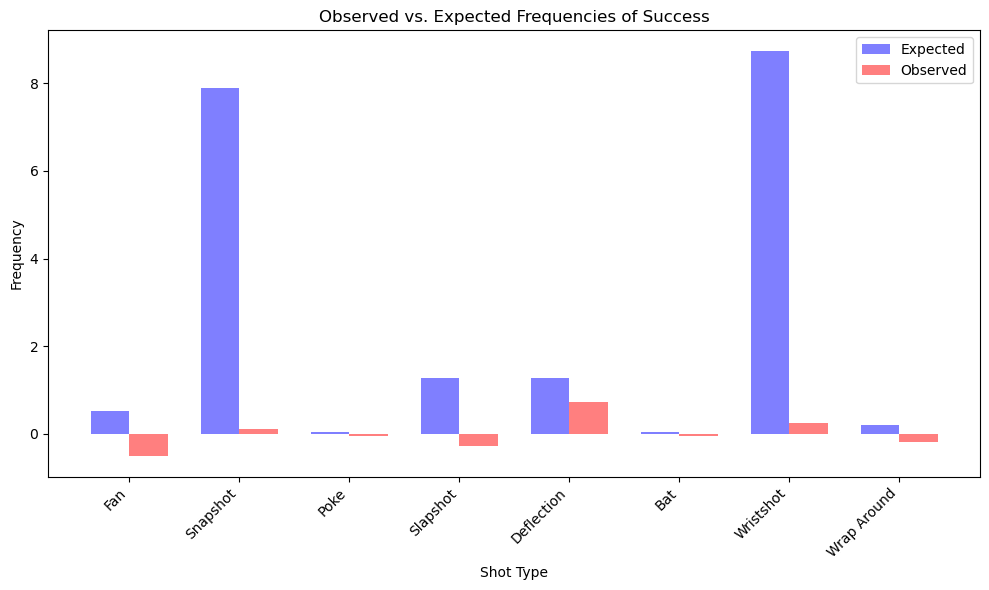

In [18]:
# Define observed and expected frequencies
observed = contingency_table[0]
expected = contingency_table[1]

categories = df["Shot Type"]

bar_width = 0.35
x = np.arange(len(categories))

# Plot observed and expected frequencies
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, expected, color='blue', width=bar_width, alpha=0.5, label='Expected')
plt.bar(x + bar_width/2, observed - expected, color='red', width=bar_width, alpha=0.5, label='Observed')
plt.xlabel('Shot Type')
plt.ylabel('Frequency')
plt.title('Observed vs. Expected Frequencies of Success')
plt.legend()
plt.xticks(ticks=x, labels=categories, rotation=45, ha='right')
plt.tight_layout()
plt.show()

This diagram represents the observed and expected frequencies of Success. The blue bars represents the number of successes that were expected and the salmon-colored bar represents the number of successes actually observed in the game. Because we only have access to the data of one game, the number of observed is far less than the number of expected goals. Because of this, we don't have enough data/evidence to draw a conclusion about which shot type leads to the most number of goals. 

We will now calculate the Phi coefficient to measure the association between the success of a shot, the total number of attempts, and the type of shot. To do this, we need  to construct a contingency table for each pair of variables. Since the Phi coefficient is typically used for two binary variables, we need to choose one variable as the binary variable and the other as the categorical variable.


In [19]:
shot_type_df = df.pivot_table(index=None, columns='Shot Type', values=['Total Attempted', 'Success', 'Success Rate'])
shot_type_df

Shot Type,Bat,Deflection,Fan,Poke,Slapshot,Snapshot,Wrap Around,Wristshot
Success,0.0,2.00,0.0,0.0,1.0,8.00,0.0,9.00
Success Rate,0.0,7.41,0.0,0.0,3.7,4.79,0.0,4.86
Total Attempted,1.0,27.00,11.0,1.0,27.0,167.00,4.0,185.00


In [25]:
def phi_coefficient(n11, n10, n01, n00):
    return (n11 * n00 - n10 * n01) / np.sqrt((n11 + n10) * (n11 + n01) * (n10 + n00) * (n01 + n00))

# Initialize lists to store phi coefficients
phi_coefficients_success = []
phi_coefficients_attempted = []
shot_types = df['Shot Type'].unique()

# Iterate over each shot type
for shot_type in shot_types:
    # Calculate the contingency table for Success vs. Shot Type
    success_column = shot_type_df.loc["Success"]
    total_attempted_column = shot_type_df.loc["Total Attempted"]

    n11 = success_column[shot_type]
    n10 = success_column[~success_column.index.isin([shot_type])].sum()  
    n01 = total_attempted_column[shot_type]
    n00 = total_attempted_column[~total_attempted_column.index.isin([shot_type])].sum()  

    # Calculate Phi coefficient for Success vs. Shot Type
    phi_success_shot_type = phi_coefficient(n11, n10, n01, n00)
    phi_coefficients_success.append(phi_success_shot_type)

    # Calculate the contingency table for Total Attempted vs. Shot Type
    success_rate_column = shot_type_df.loc["Success Rate"]

    n11 = success_rate_column[shot_type]
    n10 = success_rate_column[~success_rate_column.index.isin([shot_type])].sum()
    n01 = total_attempted_column[shot_type]
    n00 = total_attempted_column[~total_attempted_column.index.isin([shot_type])].sum()

    # Calculate Phi coefficient for Total Attempted vs. Shot Type
    phi_attempted_shot_type = phi_coefficient(n11, n10, n01, n00)
    phi_coefficients_attempted.append(phi_attempted_shot_type)

# Print the phi coefficients
print("Phi coefficients for Success vs. Shot Type:", phi_coefficients_success)
print()
print("Phi coefficients for Total Attempted vs. Shot Type:", phi_coefficients_attempted)


Phi coefficients for Success vs. Shot Type: [-0.03469758779399013, 0.0022089255246991986, -0.010342694087559725, -0.01180042410912259, 0.030362468374442488, -0.010342694087559725, 0.005292953244512393, -0.02075594683882244]

Phi coefficients for Total Attempted vs. Shot Type: [-0.0353196407395582, -0.07112877504628953, -0.010528325454632552, 0.09519736142414914, 0.2314300585546848, -0.010528325454632552, -0.08674860044698723, -0.021128352046051572]


Phi Coefficients for Success vs. Shot Type: 
In this one game, there exists a weak positive/negative correlation between the success of the shot and the Shot Type, which means that shot type isn't a method that should be used when trying to determine whether shot type can yield a greater change of getting a goal.

Phi Coefficients for Total Attempted vs. Shot Type:
Similarly, there exists a weak positive/negative correlation between an attempted shot and the shot type. Compared to the correlation above, there seems to be a bigger association with the total number of shots attempted and shot type. However at the same time, since all these phi coefficients are close to 0, shot type should not be an indicator in determining what shot type leads to the greatest number of attempts without a goal. 